# 모듈 설치

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import scipy.optimize
import pandas as pd
import numpy as np
from numpy.linalg import inv
import numpy.matlib
import math
from IPython.display import Image

# 블랙리터만 모델 구현

In [2]:
#포트폴리오 평균수익률 계산
def get_mean(W, R):
    return sum(R * W)

#포트폴리오 공분산 계산
def get_var(W, C):
    return np.dot(np.dot(W, C), W)

def get_mean_var(W, R, C):
    return sum(R * W), np.dot(np.dot(W, C), W)

In [3]:
#무위험수익률, 수익률, 공분산을 이용해 평균-분산 Frontier 계산
def solveFrontier(R, C, rf):
    #주어진 수익률에서 분산을 최소로 하는 비중 계산
    def fitness(W, R, C, r):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        #최적화 제약조건 패널티
        penalty = 100 * abs(mean - r)
        return var + penalty
    
    frontier_mean, frontier_var = [], []
    n = len(R)
    #수익률 최저와 최대 사이를 반복해 efficient frontier에 포트폴리오 추가
    for r in np.linspace(min(R), max(R), num = 20):
        #동일비중을 초기값으로 설정
        W = np.ones([n]) / n
        #최적화 함수에 전달할 제약조건
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method = 'SLSQP', constraints = c_, bounds = b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        #efficient frontier에 포트폴리오 추가
        frontier_mean.append(r)
        frontier_var.append(get_var(optimized.x, C))
    return np.array(frontier_mean), np.array(frontier_var)

In [4]:
#샤프비율을 최대로 하는 접점포트폴리오 비중 계산
def solveWeights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = get_mean_var(W, R, C)
        util = (mean - rf) / math.sqrt(var) #샤프 비율
        return 1 / util #이 함수를 minimize
    n = len(R)
    W = np.ones([n]) / n
    b_ = [(0.,1.) for i in range(n)]
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method = 'SLSQP', constraints = c_, bounds = b_)
    if not optimized.success:
        raise BaseException(optimized.message)
    return optimized.x

In [5]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var):
        self.W = W
        self.tan_mean = tan_mean
        self.tan_var = tan_var
        self.front_mean = front_mean
        self.front_var = front_var
        
def optimize_frontier(R, C, rf):
    W = solveWeights(R, C, rf)
    tan_mean, tan_var = get_mean_var(W, R, C)
    front_mean, front_var = solveFrontier(R, C, rf)
    return Result(W, tan_mean, tan_var, front_mean, front_var)

def display_assets(names, R, C, color = 'black'):
    n = len(names)
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker = 'x', color = color), plt.grid(True)
    for i in range(n):
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment = 'center', color = color)
        
def display_frontier(result, label = None, color = 'black'):
    plt.text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment = 'center', color = color)
    plt.scatter(result.tan_var ** .5, result.tan_mean, marker = 'o', color = color), plt.grid(True)
    plt.plot(result.front_var ** .5, result.front_mean, label = label, color = color), plt.grid(True)

# 주가 데이터 수집

In [6]:
#krx에서 주가 정보를 스크래핑한 모듈
from pykrx import stock
import requests
from io import BytesIO

In [7]:
#주가 정보를 불러온다
def get_stock_info(start, end, code, period):
    df = stock.get_index_ohlcv_by_date(start, end, code, period)
    return df

In [8]:
def krx(tdate):
    global health
    gen_req_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
    query_str_parms = {
        'idxIndMidclssCd' : '02',
        'trdDd': str(tdate),
        'share' : '2',
        'money' : '3',
        'csvxls_isNo' : 'false',
        'name' : 'fileDown',
        'url' : 'dbms/MDC/STAT/standard/MDCSTAT00101'
    }
    headers = {
        'Referer' :'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020101',
        'Upgrade-Insecure-Requests' : '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36'
    }
    r = requests.get(gen_req_url, query_str_parms, headers = headers)
    code = r.content
    gen_req_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
    form_data = {
        'code' : code
    }
    r = requests.post(gen_req_url, form_data)
    df = pd.read_csv(BytesIO(r.content), encoding = "CP949")
    df['일자'] = tdate
    return df

In [9]:
stock_result = pd.DataFrame()
#index가 1150부터 1160까지가 코스피200에 있는 섹터의 index
for i in range(1150, 1161):
    df = (get_stock_info("20160101", "20181231", str(i), "m")['종가']).to_frame() #종가만 모아놓은 df
    stock_result = pd.concat([stock_result, df], axis = 1)
stock_result.columns = ['커뮤니케이션서비스', '건설', '중공업', '철강/소재', '에너지/화학', '정보기술', '금융', '생활소비재', '경기소비재', '산업재', '헬스케어']
stock_result #각 섹터의 2016년부터 2018년까지 월별 평균 종가로 이루어진 dataframe

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
날짜,,,,,,,,,,,
2016-01-31,1341.03,277.00,231.22,758.78,1132.45,1272.85,627.40,1450.79,1676.78,680.57,2552.91
2016-02-29,1350.01,265.50,245.08,828.05,1199.59,1291.59,621.56,1425.30,1718.37,650.42,2284.10
2016-03-31,1383.23,293.29,273.78,888.98,1334.94,1323.00,662.24,1424.28,1716.43,648.50,2409.25
2016-04-30,1378.60,306.94,296.99,967.57,1234.93,1303.60,671.65,1487.29,1702.45,680.16,2312.11
2016-05-31,1445.34,270.08,280.51,847.41,1199.57,1343.82,644.16,1525.80,1652.26,671.26,2486.10
2016-06-30,1394.82,259.22,275.87,835.72,1119.55,1375.63,615.34,1516.05,1607.52,669.86,2542.87
2016-07-31,1455.92,278.78,315.14,901.30,1142.20,1447.65,648.65,1459.20,1598.55,681.54,2351.46
2016-08-31,1517.42,275.24,335.97,885.80,1148.38,1537.80,668.04,1400.46,1626.75,707.47,2275.89
2016-09-30,1577.03,278.86,333.83,880.24,1165.19,1547.61,666.44,1418.13,1661.16,686.53,2205.59


In [10]:
symbols = stock_result.columns.tolist()

In [11]:
total = pd.DataFrame()
m = pd.DataFrame()
for year in range(2019, 2020):
    for month in range(1, 13):
        m = m.iloc[0:0]
        for day in range(1, 32):
            tdate = int(year*10000+month*100+day*1)
            if tdate <= 20191231:
                data = krx(tdate)
                data = data.iloc[7:18, :]
                data = data[['상장시가총액']]
                data = data.transpose()
                m = pd.concat([m, data])
        m = m.dropna(axis = 0)
        m_mean = m.mean()
        m_mean = m_mean/m_mean.sum()
        m_mean = m_mean.to_frame()
        m_mean = m_mean.transpose()
        index = str(year)+'/'+str(month)
        m_mean.index = [index]
        total = pd.concat([total, m_mean])
total.columns = symbols
date = total.index.tolist()
total

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,0.076454,0.026597,0.032028,0.035074,0.091960,0.309232,0.110532,0.105943,0.117825,0.028851,0.065503
2019/2,0.071275,0.026121,0.030314,0.034573,0.092876,0.325773,0.109693,0.102694,0.115561,0.028074,0.063046
2019/3,0.073120,0.024918,0.028777,0.034279,0.093049,0.321594,0.109497,0.107564,0.116980,0.027940,0.062282
2019/4,0.071547,0.024674,0.027823,0.034653,0.090434,0.328020,0.109950,0.104163,0.120281,0.027530,0.060926
2019/5,0.076823,0.024869,0.027465,0.033281,0.087908,0.324621,0.113708,0.101666,0.122291,0.028288,0.059080
2019/6,0.074932,0.025901,0.028861,0.033912,0.085699,0.328074,0.112517,0.097498,0.124350,0.028544,0.059711
2019/7,0.074726,0.023973,0.028147,0.033765,0.086608,0.339911,0.110271,0.095273,0.124330,0.028093,0.054903
2019/8,0.081029,0.022847,0.027483,0.032377,0.084830,0.345510,0.104952,0.093177,0.127077,0.029471,0.051246
2019/9,0.079595,0.023061,0.029433,0.032508,0.083352,0.350711,0.103548,0.092597,0.124010,0.028990,0.052195
2019/10,0.077740,0.022287,0.028619,0.031085,0.082551,0.358963,0.101414,0.092619,0.119833,0.028043,0.056847


In [12]:
total_mean = total.mean()
cap = total_mean.to_list()

In [13]:
stock_result = stock_result.transpose()
prices = stock_result.values.tolist()

#### 내재 균형 수익률

In [14]:
def assets_historical_returns_and_covariances(prices):
    prices = np.matrix(prices)
    rows, cols = prices.shape
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1 #수익률 계산
    expreturns = np.array([])
    for r in range(rows):
        expreturns = np.append(expreturns, numpy.mean(returns[r])) #평균 수익률 계산
    covars = np.cov(returns)
    return expreturns, covars

W = cap
R, C = assets_historical_returns_and_covariances(prices)
rf = 0.0169 #무위험수익률은 한국자산평가에서 제공하는 통안채 1년치 사용

#### 포트폴리오 자산 수익률과 비중

In [15]:
display(pd.DataFrame({'Return': R, 'Weight(based on market cap)': W}, index=symbols).T)

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Return,0.006186,0.00439,0.011657,0.002783,0.005064,0.012014,0.004294,-0.004059,-0.005818,-0.008444,-0.001357
Weight(based on market cap),0.076336,0.02398,0.028436,0.032955,0.086627,0.338628,0.107469,0.098195,0.120911,0.028102,0.058362


#### 포트폴리오 자산 수익률의 공분산

In [16]:
display(pd.DataFrame(C, columns = symbols, index = symbols))

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
커뮤니케이션서비스,0.002403,0.001111,0.001282,0.000663,0.000897,0.001451,0.000948,0.001190,0.001018,0.000998,0.001698
건설,0.001111,0.006998,0.005124,0.003342,0.001525,0.000889,0.001919,0.002008,0.002784,0.002603,0.003322
중공업,0.001282,0.005124,0.006868,0.002845,0.001521,0.000999,0.001565,0.001136,0.002104,0.002503,0.002596
철강/소재,0.000663,0.003342,0.002845,0.004050,0.001527,0.000780,0.001803,0.001070,0.001627,0.001494,0.001413
에너지/화학,0.000897,0.001525,0.001521,0.001527,0.002123,0.000720,0.001138,0.000437,0.001118,0.000653,0.001437
정보기술,0.001451,0.000889,0.000999,0.000780,0.000720,0.002152,0.000627,0.000425,0.000740,0.000766,0.001248
금융,0.000948,0.001919,0.001565,0.001803,0.001138,0.000627,0.002041,0.000652,0.001119,0.000870,0.000454
생활소비재,0.001190,0.002008,0.001136,0.001070,0.000437,0.000425,0.000652,0.001936,0.001418,0.001284,0.002418
경기소비재,0.001018,0.002784,0.002104,0.001627,0.001118,0.000740,0.001119,0.001418,0.002393,0.001259,0.002462
산업재,0.000998,0.002603,0.002503,0.001494,0.000653,0.000766,0.000870,0.001284,0.001259,0.002087,0.002524


### 평균 분산 포트폴리오 최적화

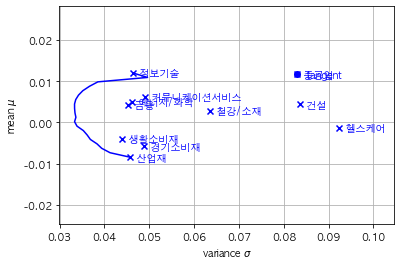

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,3.103854e-11,2.273887e-11,1.0,4.124469e-11,3.466807e-11,8.492871e-12,3.772688e-11,7.482418e-11,7.962232e-11,8.899085e-11,6.083805e-11


In [17]:
#평균분산모델
res1 = optimize_frontier(R, C, rf)

display_assets(symbols, R, C, color = 'blue')
display_frontier(res1, color = 'blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
display(pd.DataFrame({'Weight': res1.W}, index = symbols).T)

### 블랙 리터만 역최적화

In [18]:
mean, var = get_mean_var(W, R, C)

lmb = 3 #위험회피계수는 여러 연구에서 사용하고 있는 3을 사용
Pi = np.dot(np.dot(lmb, C), W)

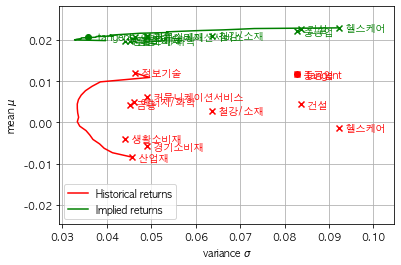

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,0.076617,0.023941,0.028449,0.032978,0.086632,0.338472,0.107322,0.098032,0.121004,0.028266,0.058287


In [19]:
#균형수익률로 평균-분산 포트폴리오 최적화
res2 = optimize_frontier(Pi+rf, C, rf)

#빨간색 그래프는 평균분산 포트폴리오
display_assets(symbols, R, C, color = 'red')
display_frontier(res1, label = 'Historical returns', color = 'red')
#초록색 그래프는 블랙 리터만 평균 분산 포트폴리오
display_assets(symbols, Pi+rf, C, color = 'green')
display_frontier(res2, label = 'Implied returns', color = 'green')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': res2.W}, index = symbols).T)

#### 평균분산모델과 블랙리터만모델의 차이

(array([0, 1]), <a list of 2 Text xticklabel objects>)

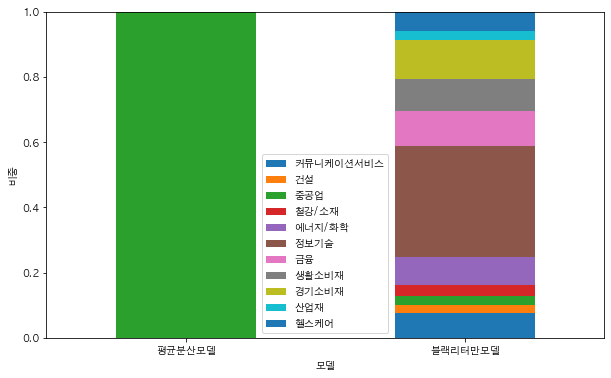

In [20]:
mean_var = pd.DataFrame({'평균분산모델': res1.W}, index = symbols).T
black_litter = pd.DataFrame({'블랙리터만모델': res2.W}, index = symbols).T
weight = pd.concat([mean_var, black_litter])

weight.plot.bar(stacked = True, figsize = (10, 6))
plt.xlabel("모델")
plt.ylabel("비중")
plt.xticks(rotation = 0)

평균 분산 모델을 사용했을 때보다 일부 종목에 집중된 포트폴리오를 최적해로 제시하는 코너해 문제가 있는 것을 확인할 수 있는데 블랙 리터만 평균 분산 모델은 평균 분산 모델보다 일부 종목에 집중되어 있지 않은, 코너해 문제를 해결한 모습을 보인다.

### 투자자 전망 행렬

In [21]:
from sklearn import svm, model_selection

In [22]:
#주가지수가 상승하면 +1, 그대로면 0을, 하락하면 -1을 넣는 return 열을 만드는 함수
def make_return(data):
    return_list = [0]
    for i in range(len(data)-1):
        if (data.iloc[i+1][0]/data.iloc[i][0])-1 > 0:
            return_list.append(1)
        elif (data.iloc[i+1][0]/data.iloc[i][0])-1 == 0:
            return_list.append(0)
        else:
            return_list.append(-1)
    data['return'] = return_list

In [23]:
accuracy_set = [] #전망의 신뢰도 
forecast_set = pd.DataFrame() #주가 지수 상승/하락 예측값
for i in range(1150, 1161):
    a = 0
    arr = get_stock_info("20160101", "20191231", str(i), "m")['종가'] #평균 수익률
    df = arr.to_frame()
    df['분산'] = np.std(np.array(arr)) #표준편차
    stoc = [] #stochastics
    for k in range(len(df)):
        stoc.append((df['종가'].values[k]-df['종가'].min())/(df['종가'].max()-df['종가'].min())*100)
    df['stochastics'] = stoc
    disparity = [] #이격도
    for k in range(len(df)):
        disparity.append(df['종가'].values[k]/df['종가'].mean() * 100)
    df['이격도'] = disparity
    make_return(df)
    y_return = df['return']
    y_lately = y_return.iloc[36:]
    y_lately = np.array(y_lately)
    y_train = y_return.iloc[:36]
    y_train = np.array(y_train)
    X = df.drop(['return'], 1)
    X_lately = X.iloc[36:, :]
    X_lately = np.array(X_lately)
    X_train = X.iloc[:36, :]
    X_train = np.array(X_train)
    #2016년부터 2018년까지를 학습 데이터로 활용하고 2019년 1년 후의 데이터를 예측한다.
    model = svm.SVC(kernel = 'rbf', C = 1.25, gamma = 0.1)
    model.fit(X_train, y_train)
    forecast = model.predict(X_lately)
    accuracy = model.score(X_lately, y_lately)
    accuracy_set.append(accuracy)
    forecast_set.insert(a, str(a), forecast, True)
    a += 1
forecast_set.columns = ['커뮤니케이션서비스', '건설', '중공업', '철강/소재', '에너지/화학', '정보기술', '금융', '생활소비재', '경기소비재', '산업재', '헬스케어']
print(accuracy_set)
forecast_set.index = date
forecast_set

[0.5833333333333334, 0.4166666666666667, 0.5, 0.5, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334, 0.5, 0.5833333333333334, 0.4166666666666667, 0.5833333333333334]


,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,1,-1,1,-1,1,1,1,-1,1,1,1
2019/2,1,-1,-1,-1,1,1,1,-1,1,-1,-1
2019/3,1,-1,-1,-1,-1,1,1,-1,-1,1,1
2019/4,1,-1,-1,-1,1,-1,1,-1,-1,1,1
2019/5,1,-1,-1,-1,-1,1,1,-1,-1,1,-1
2019/6,1,-1,-1,-1,-1,1,1,-1,-1,1,-1
2019/7,1,-1,-1,-1,1,1,-1,-1,-1,1,1
2019/8,1,-1,-1,-1,1,1,-1,-1,-1,1,1
2019/9,1,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/10,1,-1,-1,-1,1,1,1,-1,-1,1,1


In [24]:
#투자자 전망, 신뢰도에 대한 데이터가 주어졌을 때 새로운 기대수익률과 공분산을 구하는 함수
def cal_RC(accuracy_set, forecast_set, Pi, C):
    #투자자 전망에 나타나는 신뢰도 수준은 불확실성계수로 오차항에 반영
    confidence = np.identity(11)
    for i in range(0, 11):
        confidence[i][i] = (1-accuracy_set[i])/accuracy_set[i]
    
    #예측 분류 결과로부터 투자자 전망 Q 계산
    P = np.identity(11)
    sub = np.dot(P, Pi)
    Q = np.sqrt(np.dot(np.dot(P, C), np.ones(11)))
    for i in range(0, 11):
        Q[i] = Q[i] * forecast_set.iloc[11][i]
    Q += sub
    
    tau = 0.025 #상대적 가중치를 나타내는데 많은 연구에서 사용하는 0.025를 활용했다
    #전망에 대한 신뢰도 수준을 사용해 투자자 전망의 불확실성을 고려
    omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))
    omega = np.dot(confidence, omega)

    sub_a = np.linalg.inv(np.dot(tau, C))
    sub_b = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P)
    sub_c = np.dot(np.linalg.inv(np.dot(tau, C)), Pi)
    sub_d = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)
    new_R = np.dot(np.linalg.inv(sub_a + sub_b), (sub_c + sub_d)) #새로운 결합기대수익률 벡터
    new_C = C + np.linalg.inv(sub_a + sub_b) #새로운 공분산행렬
    
    return new_R, new_C

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,0.099653,1.425455e-16,0.0,2.229391e-16,0.201286,0.22514,0.342025,0.0,0.0,0.030059,0.101837


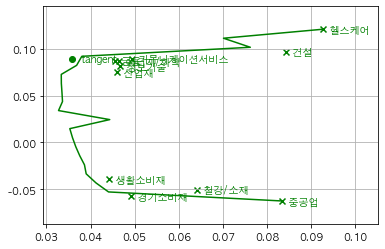

In [25]:
new_R, new_C = cal_RC(accuracy_set, forecast_set, Pi, C)
res3 = optimize_frontier(new_R+rf, new_C, rf)
display_assets(symbols, new_R+rf, new_C, color = 'green')
display_frontier(res3, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res3.W}, index = symbols).T)

In [26]:
result = pd.DataFrame()
for i in range(1150, 1161):
    df = (get_stock_info("20181201", "20191231", str(i), "m")['종가']).to_frame()
    result = pd.concat([result, df], axis = 1)
date2 = (result.index).strftime("%Y-%m-%d").to_list()
result = result.values.tolist()
result = np.matrix(result)
rows, cols = result.shape
returns = np.empty([rows-1, cols])
for c in range(cols):
    for r in range(rows-1):
        p0, p1 = result[r, c], result[r+1, c]
        returns[r, c] = (p1 / p0) - 1
returns = pd.DataFrame(returns)
returns.columns = symbols
returns.index = date2[1:]

In [27]:
def accumulate_return(res):
    return_accum = returns
    remean = [0 for i in range(return_accum.shape[0])]
    return_accum["return"] = remean
    return_mean = []
    for j in range(return_accum.shape[0]):
        Ret = return_accum.iloc[j].to_list()
        Ret.pop()
        mean = get_mean(res.W, Ret)
        return_mean.append(mean)
    return_accum["return"] = return_mean
    return return_accum

acc_re = accumulate_return(res3)
acc_re

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,-0.012138,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.054261
2019-02-28,0.013111,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,0.008029
2019-03-31,-0.003547,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.035685
2019-04-30,0.013672,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.022940
2019-05-31,-0.034493,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.060823
2019-06-30,0.024937,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.032502
2019-07-31,-0.009161,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.045638
2019-08-31,0.032172,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.039736
2019-09-30,0.016245,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.028051
2019-10-31,0.001866,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,0.017712


누적 수익률: 3.67


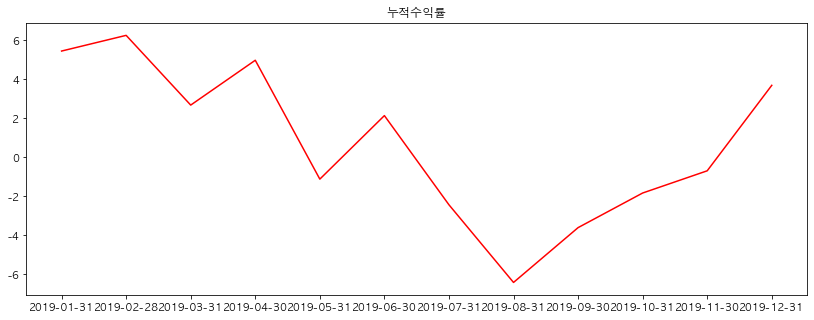

In [28]:
cum_return = acc_re[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return[-1])
plt.figure(figsize = (14, 5))
plt.plot(cum_return, color = 'red')
plt.title("누적수익률")
plt.show()

In [29]:
std = cum_return.std()

sharpe = (cum_return - rf)/std
sharpe = sharpe[-1]
print('Sharpe ratio: %.2f' % sharpe)

Sharpe ratio: 0.91


#### 예측값 사용하여 다음 달 예측

In [30]:
def pred_past(train):
    accuracy_set2 = [] #전망의 신뢰도 
    forecast_set2 = pd.DataFrame() #주가 지수 상승/하락 예측값
    for i in range(1150, 1161):
        train_set = train
        train_original = train_set
        a = 0
        arr = get_stock_info("20160101", "20191231", str(i), "m")['종가']
        df = arr.to_frame()
        df['분산'] = np.std(np.array(arr)) #표준편차
        stoc = [] #stochastics
        for k in range(len(df)):
            stoc.append((df['종가'].values[k]-df['종가'].min())/(df['종가'].max()-df['종가'].min())*100)
        df['stochastics'] = stoc
        disparity = [] #이격도
        for k in range(len(df)):
            disparity.append(df['종가'].values[k]/df['종가'].mean() * 100)
        df['이격도'] = disparity
        make_return(df)
        y_return = df['return']
        y = np.array(y_return)
        X = df.drop(['return'], 1)
        X = np.array(X)
        L = X.shape[0]
        acc =[]
        while train_set < (L - 2):
            X_train = X[train_set-train_original:train_set]
            y_train = y[train_set-train_original:train_set]
            X_test = X[train_set:train_set+1]
            y_test = y[train_set:train_set+1]
            model = svm.SVC(kernel = 'rbf', C = 1.25, gamma = 0.1)
            model.fit(X_train, y_train)
            forecast = model.predict(X_test)
            accuracy = model.score(X_test, y_test)
            acc.append(accuracy)
            y[train_set] = forecast[0]
            a += 1
            train_set += 1
        accuracy_set2.append(np.mean(acc))
        y_lately = y[36:]
        forecast_set2[i] = y_lately
    forecast_set2.columns = ['커뮤니케이션서비스', '건설', '중공업', '철강/소재', '에너지/화학', '정보기술', '금융', '생활소비재', '경기소비재', '산업재', '헬스케어']
    return accuracy_set2, forecast_set2

#### 30개월치 데이터를 이용해서 예측

In [31]:
accuracy_set30, forecast_set30 = pred_past(30)
forecast_set30.index = date
forecast_set30

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,1,1,-1,-1,1,1,1,-1,-1,-1,1
2019/2,1,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/3,1,1,-1,-1,1,1,-1,-1,-1,-1,1
2019/4,1,1,-1,-1,1,1,1,-1,-1,-1,1
2019/5,-1,1,-1,-1,1,1,-1,-1,-1,-1,1
2019/6,1,1,-1,-1,1,1,1,-1,-1,-1,1
2019/7,1,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/8,1,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/9,1,-1,-1,-1,1,1,1,-1,-1,-1,1
2019/10,1,-1,-1,-1,1,1,1,-1,-1,-1,1


,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,0.349352,0.040971,0.078155,0.025036,0.125118,0.09377,0.054567,0.222921,4.065758e-19,2.710505e-19,0.01011


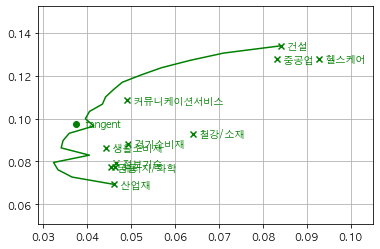

In [32]:
new_R, new_C = cal_RC(accuracy_set30, forecast_set30, Pi, C)
res30 = optimize_frontier(new_R+rf, new_C, rf)
display_assets(symbols, new_R+rf, new_C, color = 'green')
display_frontier(res30, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res30.W}, index = symbols).T)

In [33]:
acc_re30 = accumulate_return(res30)
acc_re30

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,-0.012138,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.030419
2019-02-28,0.013111,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,0.006732
2019-03-31,-0.003547,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.022356
2019-04-30,0.013672,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.007486
2019-05-31,-0.034493,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.061935
2019-06-30,0.024937,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.025353
2019-07-31,-0.009161,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.036133
2019-08-31,0.032172,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.012345
2019-09-30,0.016245,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.031595
2019-10-31,0.001866,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,-0.000164


누적 수익률: 0.95


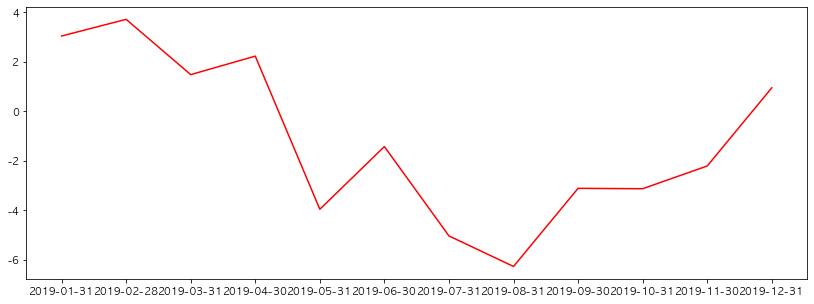

In [34]:
cum_return30 = acc_re30[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return30[-1])
plt.figure(figsize = (14, 5))
plt.plot(cum_return30, color = 'red')
plt.show()

In [35]:
std = cum_return30.std()

sharpe = (cum_return30 - rf)/std
sharpe = sharpe[-1]
print('Sharpe ratio: %.2f' % sharpe)

Sharpe ratio: 0.28


#### 예측에 사용되는 개월수 차이로 인한 평균수익률과 샤프지수의 변화

In [36]:
past_n = []
mean_set = []
sharpe_set = []
for n in range(30, 41):
    past_n.append(n)
    accuracyset, forecastset = pred_past(n)
    new_R, new_C = cal_RC(accuracyset, forecastset, Pi, C)
    front = optimize_frontier(new_R+rf, new_C, rf)
    acc_re = accumulate_return(front)
    cum_return = acc_re[:]['return'].cumsum()*100
    mean_set.append(cum_return[-1])
    std = cum_return.std()
    sharpe = (cum_return - rf)/std
    sharpe = sharpe[-1]
    sharpe_set.append(sharpe)

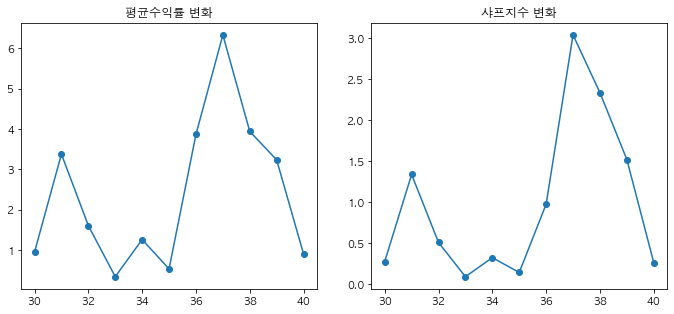

In [37]:
fig = plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(past_n, mean_set, marker = 'o')
plt.title('평균수익률 변화')

plt.subplot(1, 2, 2)
plt.plot(past_n, sharpe_set, marker = 'o')
plt.title('샤프지수 변화')

plt.tight_layout(3)
plt.show()

## RNN 이용

In [38]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score

In [39]:
def create_dataset(dataset, look_back):
    x_arr, y_arr = [], []
    for i in range(len(dataset) - look_back):
        col = dataset.shape[1]
        x_arr.append(dataset[i:(i+look_back), 0])
        y_arr.append(dataset[i+look_back, 0])
    
    x_arr = np.array(x_arr)
    x_arr = np.reshape(x_arr, (x_arr.shape[0], x_arr.shape[1], 1))
    return x_arr, np.array(y_arr)

In [40]:
forecast_set = pd.DataFrame(columns = symbols) #주가 지수 상승/하락 예측값
look_back = 6
batch_size = 3
n = 0
for i in range(1150, 1161):
    arr = get_stock_info("20160101", "20191231", str(i), "m")['종가']
    df = arr.to_frame()
    train = df.iloc[:36, :]
    train = np.array(train)
    test = df.iloc[35-look_back+1:, :]
    test = np.array(test)
    x_train, y_train = create_dataset(train, look_back)
    x_test, y_test = create_dataset(test, look_back)
    #모델 생성
    model = Sequential()
    model.add(LSTM(64, batch_input_shape = (batch_size, look_back, 1), stateful = True, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, batch_input_shape = (batch_size, look_back, 1), stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
    hist = model.fit(x_train, y_train, epochs = 10, batch_size=batch_size)
    predictions = model.predict(x_test, batch_size)
    predictions = predictions.reshape(-1)
    predictions = np.insert(predictions, 0, y_train[-1], axis = 0)
    pred = pd.DataFrame(predictions)
    make_return(pred)
    forecast_set[symbols[n]] = pred['return']
    n += 1
forecast_set

Train on 30 samples
Epoch 1/10
30/30 [==============================] - 6s 208ms/sample - loss: 2730144.0000 - accuracy: 0.0000e+00
Epoch 2/10
30/30 [==============================] - 0s 6ms/sample - loss: 2726005.3500 - accuracy: 0.0000e+00
Epoch 3/10
30/30 [==============================] - 0s 6ms/sample - loss: 2721642.1750 - accuracy: 0.0000e+00
Epoch 4/10
30/30 [==============================] - 0s 5ms/sample - loss: 2718388.0750 - accuracy: 0.0000e+00
Epoch 5/10
30/30 [==============================] - 0s 7ms/sample - loss: 2714506.0250 - accuracy: 0.0000e+00
Epoch 6/10
30/30 [==============================] - 0s 7ms/sample - loss: 2712199.0250 - accuracy: 0.0000e+00
Epoch 7/10
30/30 [==============================] - 0s 6ms/sample - loss: 2710518.7000 - accuracy: 0.0000e+00
Epoch 8/10
30/30 [==============================] - 0s 6ms/sample - loss: 2707014.0500 - accuracy: 0.0000e+00
Epoch 9/10
30/30 [==============================] - 0s 6ms/sample - loss: 2704638.5500 - accuracy:

30/30 [==============================] - 0s 5ms/sample - loss: 1716887.8750 - accuracy: 0.0000e+00
Epoch 5/10
30/30 [==============================] - 0s 5ms/sample - loss: 1713617.7250 - accuracy: 0.0000e+00
Epoch 6/10
30/30 [==============================] - 0s 5ms/sample - loss: 1711357.6000 - accuracy: 0.0000e+00
Epoch 7/10
30/30 [==============================] - 0s 5ms/sample - loss: 1707758.5750 - accuracy: 0.0000e+00
Epoch 8/10
30/30 [==============================] - 0s 5ms/sample - loss: 1707422.5625 - accuracy: 0.0000e+00
Epoch 9/10
30/30 [==============================] - 0s 5ms/sample - loss: 1705584.7750 - accuracy: 0.0000e+00
Epoch 10/10
30/30 [==============================] - 0s 5ms/sample - loss: 1704127.6250 - accuracy: 0.0000e+00
Train on 30 samples
Epoch 1/10
30/30 [==============================] - 5s 162ms/sample - loss: 2408005.0000 - accuracy: 0.0000e+00
Epoch 2/10
30/30 [==============================] - 0s 6ms/sample - loss: 2403630.1875 - accuracy: 0.0000e+0

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
0,0,0,0,0,0,0,0,0,0,0,0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,1,-1,-1,1,-1,-1,-1,1,1,-1
3,1,-1,1,1,-1,1,1,1,-1,-1,-1
4,1,-1,1,-1,1,1,1,1,1,-1,1
5,-1,0,1,-1,1,-1,-1,-1,1,1,-1
6,1,-1,1,1,0,1,1,-1,-1,-1,-1
7,1,1,-1,-1,1,1,1,1,1,-1,1
8,-1,-1,1,-1,1,-1,-1,-1,1,1,-1
9,1,-1,1,0,0,1,1,-1,-1,-1,-1


In [41]:
forecast_set = forecast_set.drop(forecast_set.index[0])
forecast_set.index = date
forecast_set

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
2019/1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2019/2,-1,1,-1,-1,1,-1,-1,-1,1,1,-1
2019/3,1,-1,1,1,-1,1,1,1,-1,-1,-1
2019/4,1,-1,1,-1,1,1,1,1,1,-1,1
2019/5,-1,0,1,-1,1,-1,-1,-1,1,1,-1
2019/6,1,-1,1,1,0,1,1,-1,-1,-1,-1
2019/7,1,1,-1,-1,1,1,1,1,1,-1,1
2019/8,-1,-1,1,-1,1,-1,-1,-1,1,1,-1
2019/9,1,-1,1,0,0,1,1,-1,-1,-1,-1
2019/10,1,1,-1,1,1,1,1,1,1,-1,1


In [42]:
acc_set = []
n = 0
for i in range(1150, 1161):
    count = 0
    arr = get_stock_info("20181201", "20191231", str(i), "m")['종가'] #평균 수익률
    df = arr.to_frame()
    make_return(df)
    ret = df['return'].to_list()
    ret = ret[1:]
    for i in range(len(ret)):
        if ret[i] == forecast_set[symbols[n]].tolist()[i]:
            count += 1
    acc = count / len(ret)
    acc_set.append(acc)
    n += 1
print(acc_set)

[0.5833333333333334, 0.25, 0.6666666666666666, 0.5, 0.25, 0.5833333333333334, 0.5833333333333334, 0.5, 0.25, 0.4166666666666667, 0.5]


,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어
Weight,2.831558e-16,3.681476e-17,0.127858,4.240229e-18,0.0,0.294975,0.283825,0.293342,5.574290e-17,0.0,2.657755e-16


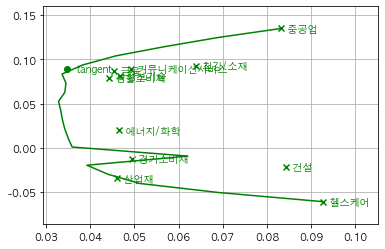

In [43]:
new_R, new_C = cal_RC(acc_set, forecast_set, Pi, C)
res = optimize_frontier(new_R+rf, new_C, rf)
display_assets(symbols, new_R+rf, new_C, color = 'green')
display_frontier(res, label = 'Implied returns(adjusted views)', color = 'green')
display(pd.DataFrame({'Weight':res.W}, index = symbols).T)

In [44]:
acc_re = accumulate_return(res)
acc_re

,커뮤니케이션서비스,건설,중공업,철강/소재,에너지/화학,정보기술,금융,생활소비재,경기소비재,산업재,헬스케어,return
2019-01-31,-0.012138,0.055769,0.083829,0.089659,0.057175,0.118027,0.045569,0.012838,0.099340,0.057069,0.000865,0.062233
2019-02-28,0.013111,-0.059637,-0.055405,0.005186,0.023433,0.006467,-0.006603,0.024271,-0.003373,0.024143,0.020449,0.000069
2019-03-31,-0.003547,-0.011572,-0.082894,-0.041814,-0.054772,-0.000663,-0.038703,-0.014308,-0.032294,-0.061369,-0.089118,-0.025976
2019-04-30,0.013672,0.000676,0.009993,-0.000061,-0.015489,0.028377,0.040304,-0.006108,0.090269,0.035848,0.033821,0.019295
2019-05-31,-0.034493,-0.046657,-0.057796,-0.085140,-0.073631,-0.085049,-0.037443,-0.094890,-0.090617,-0.037509,-0.093122,-0.070939
2019-06-30,0.024937,0.047038,0.043019,0.056264,0.018989,0.062248,0.029651,-0.000241,0.038667,0.012120,0.016442,0.032207
2019-07-31,-0.009161,-0.126510,-0.080301,-0.068654,-0.026791,-0.022664,-0.056324,-0.043701,-0.045795,-0.007957,-0.144604,-0.045758
2019-08-31,0.032172,-0.045110,0.013854,-0.060294,-0.040485,-0.019796,-0.078256,-0.043726,-0.011257,0.005360,-0.036643,-0.039106
2019-09-30,0.016245,0.056082,0.073460,0.045539,-0.004337,0.037597,0.044068,0.049390,0.036162,0.010583,0.033881,0.047478
2019-10-31,0.001866,-0.046390,-0.073012,-0.083678,0.031054,0.019469,-0.029233,0.013615,-0.029753,-0.019557,0.171625,-0.007895


누적 수익률: 2.37


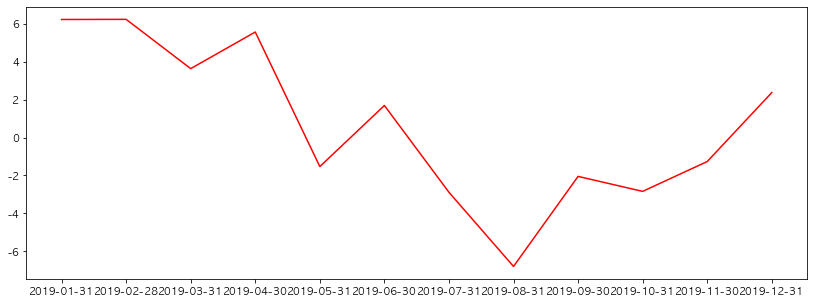

In [45]:
cum_return = acc_re[:]['return'].cumsum()*100
print('누적 수익률: %.2f' % cum_return[-1])
plt.figure(figsize = (14, 5))
plt.plot(cum_return, color = 'red')
plt.show()

In [46]:
std = cum_return.std()

sharpe = (cum_return - rf)/std
sharpe = sharpe[-1]
print('Sharpe ratio: %.2f' % sharpe)

Sharpe ratio: 0.56
